In [1]:
from brian2 import *
%matplotlib inline

INFO       Cache size for target 'cython': 2579977803 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\admin\.cython\brian_extensions' directory. [brian2]


In [2]:
# Constants
tau = 4*ms
I = 1.1/ms
gamma = 1/ms

# Non-dimensionalized constants
tp = tau/ms
curr = I*ms
g = gamma*ms
out = curr/g  #should be > the threshold of firing

# equation (1)
eqs = '''
dv/dt = I - gamma*v : 1
'''

# equation (2) 
eqs2 = '''
dv/dt = ((I/gamma) - v)/tau : 1
'''

In [3]:
start_scope()

inh = 0.001
exc = 0.001
n = 81
seed(21)


G1 = NeuronGroup(n, eqs2, threshold='v>1', reset='v = 0', method='exact')
groupinit = randint(0, 99, size=n)/100
G1.v = groupinit

In [4]:
sudo = G1.i[:].reshape(9, 9)

In [5]:
subgrid = -1
subgrids = [[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)], #0
            [(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5)], #1
            [(0,6),(0,7),(0,8),(1,6),(1,7),(1,8),(2,6),(2,7),(2,8)], #2
            [(3,0),(3,1),(3,2),(4,0),(4,1),(4,2),(5,0),(5,1),(5,2)], #3
            [(3,3),(3,4),(3,5),(4,3),(4,4),(4,5),(5,3),(5,4),(5,5)], #4
            [(3,6),(3,7),(3,8),(4,6),(4,7),(4,8),(5,6),(5,7),(5,8)], #5
            [(6,0),(6,1),(6,2),(7,0),(7,1),(7,2),(8,0),(8,1),(8,2)], #6
            [(6,3),(6,4),(6,5),(7,3),(7,4),(7,5),(8,3),(8,4),(8,5)], #7
            [(6,6),(6,7),(6,8),(7,6),(7,7),(7,8),(8,6),(8,7),(8,8)] #8
            ]

def getsubgrid(i,j):
        if i<3:
                if j<3:
                        subgrid = 0
                if j>2 and j<6:
                        subgrid = 1
                if j>5 and j<9:
                        subgrid = 2
        elif i>2 and i<6:
                if j<3:
                        subgrid = 3
                if j>2 and j<6:
                        subgrid = 4
                if j>5 and j<9:
                        subgrid = 5
        elif i>5 and i<9:
                if j<3:
                        subgrid = 6
                if j>2 and j<6:
                        subgrid = 7
                if j>5 and j<9:
                        subgrid = 8
        return subgrids[subgrid]

In [6]:
def matcon(i,j):
        matrix[i, j] = 1

def connectrowcol(i,j):
        for y in range(9):
                if y == i:
                        pass;
                else:
                        matcon(sudo[i,j], sudo[y,j])
        for x in range(9):
                if x == j:
                        pass;
                else:
                        matcon(sudo[i,j], sudo[i,x])

def connectsub(i,j):
        for (x,y) in getsubgrid(i,j):
                if (x,y) != (i,j):
                        matcon(sudo[i,j], sudo[x,y])

def inhibconnect():
        for i in range(9):
                for j in range(9):
                        connectrowcol(i,j)
                        connectsub(i,j)

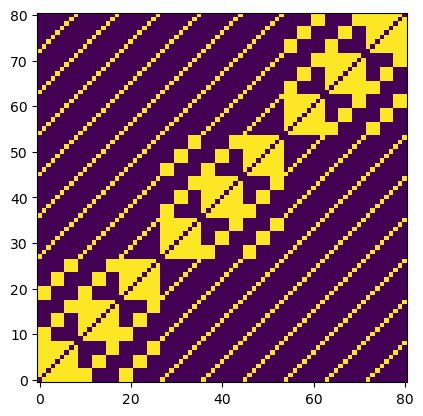

In [7]:
matrix = zeros((n, n))

inhibconnect()

imshow(matrix, origin='lower');

In [ ]:
from collections import Counter


In [8]:
exc_matrix = 1 - matrix

si, ti = matrix.nonzero()
se, te = exc_matrix.nonzero()

In [9]:
# Inhibitory synapses
I1 = Synapses(G1, G1, on_pre='v = out * (1-exp(-(tp * log(1/(1 - g*(v_post - inh)/curr)))/tp))')

# Excitatory synapses
E1 = Synapses(G1, G1, on_pre='v = out * (1-exp(-(tp * log(1/(1 - g*(v_post + exc)/curr)))/tp))')

I1.connect(i=si, j=ti)

E1.connect(i=se, j=te)

M1 = StateMonitor(G1, 'v', record=True)
Sp1 = SpikeMonitor(G1)

In [10]:
run(500*ms)

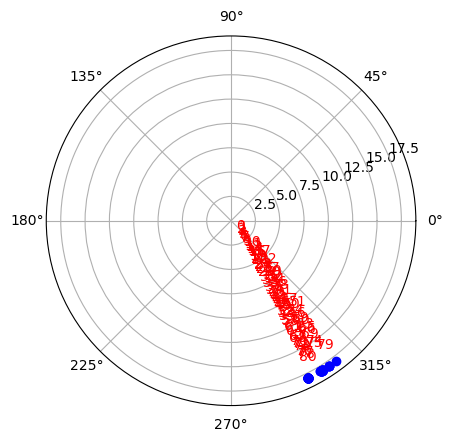

In [11]:
alph = 0.2
t = 4999

for x in range(n):
	polar(M1.v[x][t] * 2*pi, 18, 'bo')
	annotate(x, (M1.v[x][t] * 2*pi, linspace(1, 16, n)[x]), color = 'red')